In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [8]:
spikes[:, :18].shape

(360000, 18)

In [9]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)

decoder = SortedSpikesDecoder(movement_var=movement_var,
                              replay_speed=1,
                              place_bin_size=np.sqrt(movement_var),
                              knot_spacing=10)
decoder.fit(position, spikes[:, :18])

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.2775841643294236,
                    place_bin_size=0.5268625668325884, position_range=None,
                    replay_speed=1, spike_model_penalty=10.0,
                    transition_type='random_walk')

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


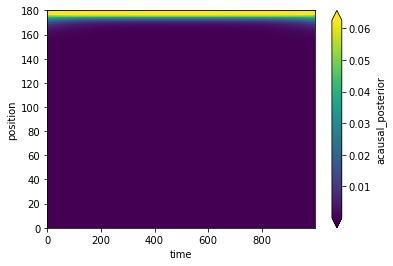

In [17]:
results = decoder.predict(np.zeros((1_000, 18)))
results.acausal_posterior.plot(x='time', y='position', robust=True)

INFO:replay_trajectory_classification.decoder:Estimating likelihood...
INFO:replay_trajectory_classification.decoder:Estimating causal posterior...
INFO:replay_trajectory_classification.decoder:Estimating acausal posterior...


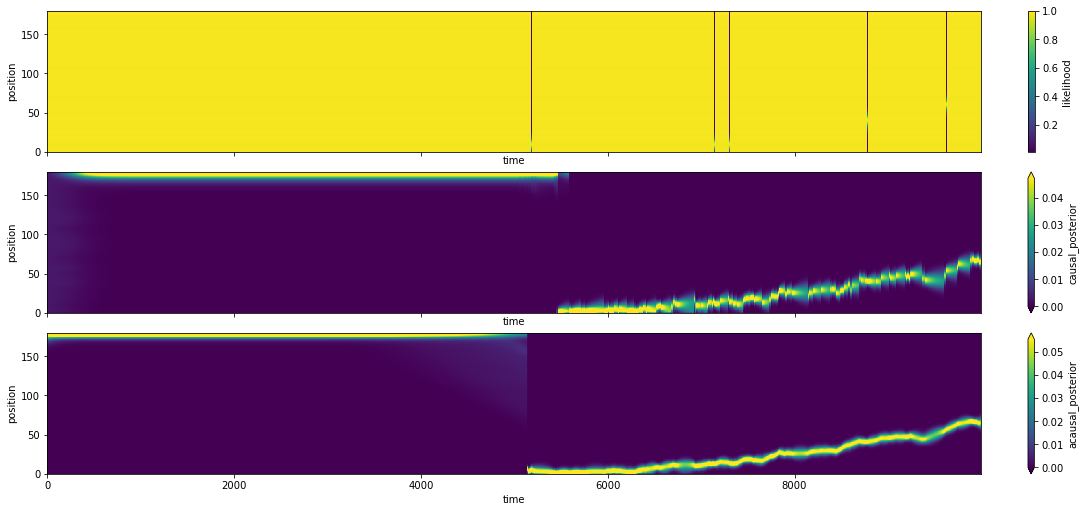

In [39]:
results = decoder.predict(np.concatenate((np.zeros((5_000, 18)),
                                          spikes[:5000, :18]), axis=0))

fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(15, 7), constrained_layout=True)
results.likelihood.plot(x='time', y='position', ax=axes[0])
results.causal_posterior.plot(x='time', y='position', robust=True, ax=axes[1])
results.acausal_posterior.plot(x='time', y='position', robust=True, ax=axes[2])

In [41]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var


classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=1,
                                    place_bin_size=np.sqrt(movement_var),
                                    knot_spacing=10)
classifier.fit(position, spikes[:, :18])

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.99,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=0.2775841643294236,
                       place_bin_size=0.5268625668325884, position_range=None,
                       replay_speed=1, spike_model_penalty=10.0)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


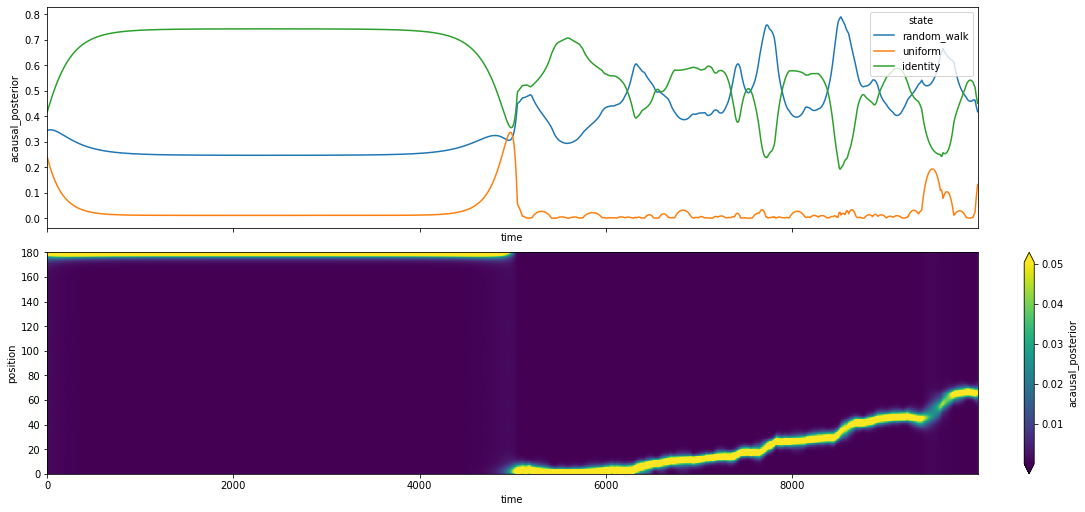

In [43]:
results = classifier.predict(np.concatenate((np.zeros((5_000, 18)),
                                          spikes[:5000, :18]), axis=0))

fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15, 7), constrained_layout=True)

results.acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[0])
results.acausal_posterior.sum('state').plot(x='time', y='position', robust=True, ax=axes[1])